# Non-Stationary Section Code
This notebook is meant for holding only non-stationary related exploration.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict

import seaborn as sns

## Pre-processing

In [24]:
DATA_DIR = 'data'
INPUT_DIR = 'input'
OUTPUT_DIR = 'output'
INPUT_PATH = f'{DATA_DIR}/{INPUT_DIR}'
OUTPUT_PATH = f'{DATA_DIR}/{OUTPUT_DIR}'

In [25]:
df = pd.read_csv(f'{INPUT_PATH}/sectoral_fundamentals.csv')
sector_column = 'gicdesc'
date_column = 'public_date'
df[date_column] = pd.to_datetime(df[date_column])
df = df.set_index([sector_column, date_column])

In [26]:
percent_cols = [col for col in df.columns if df[col].dtype == "object" and df[col].str.contains('%').any()]
for col in percent_cols:
    df[col] = df[col].str.rstrip('%').astype('float') / 100

#### Create Simulated portfolio

In [27]:
target_columns = ['simulated_portfolio_value']
returns_col = ['indret_ew']

# Define the initial portafolio value
initial_portafolio_value = 10000

# Convert MoM percentage change to multiplicative factors
df['multiplicative_factor'] = 1 + df[returns_col]
# Calculate the cumulative product of multiplicative factors
df['cumulative_factor'] = df['multiplicative_factor'].cumprod()

# Calculate the market capitalization using the cumulative factor
df[target_columns[0]] = initial_portafolio_value * df['cumulative_factor']
df[target_columns] = df[target_columns].shift(-1)

df = df.drop(columns=['multiplicative_factor', 'cumulative_factor', 'indret_vw'] + returns_col)
# df[target_columns] = df[target_columns].shift(1)

In [28]:
source_df = df.copy()

In [29]:
sector_dict = {sector:{'source': data} for sector, data in df.groupby(sector_column)}

In [30]:
for sector in sector_dict:
    df = sector_dict[sector]['source'].copy()
    holdout_size = int(len(df) * 0.2)
    sector_dict[sector]['holdout'] = df[-holdout_size:]
    df = df[:-holdout_size]
    test_size = int(len(df) * 0.2)
    sector_dict[sector]['test'] = df[-test_size:]
    sector_dict[sector]['train'] = df[:-test_size]

## Fun Starts here

In [31]:
sector_dict.keys()

dict_keys(['Communication Services', 'Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financials', 'Health Care', 'Industrials', 'Information Technology', 'Materials', 'Real Estate', 'Utilities'])

In [32]:
train_df = sector_dict['Energy']['train'].copy()
test_df = sector_dict['Energy']['test'].copy()

In [37]:
train_df

NFIRM  PEG_1yrforward_Median  CAPEI_Median  bm_Median  \
gicdesc public_date                                                          
Energy  2010-01-31     224                 -0.184         8.692      0.748   
        2010-02-28     226                 -0.094         9.396      0.702   
        2010-03-31     226                 -0.061         9.089      0.695   
        2010-04-30     225                 -0.077        10.084      0.708   
        2010-05-31     223                 -0.044         8.871      0.691   
...                    ...                    ...           ...        ...   
        2018-08-31     198                  0.011        -2.583      0.645   
        2018-09-30     200                 -0.001        -2.673      0.645   
        2018-10-31     200                 -0.004        -2.076      0.648   
        2018-11-30     200                  0.000        -1.590      0.699   
        2018-12-31     197                 -0.002        -1.212      0.704   

                     PEG_ltgforward_Median  evm_Median  pe_op_basic_Median  \
gicdesc public_date                                                          
Energy  2010-01-31                  -0.108       5.107              -0.613   
        2010-02-28                  -0.123       7.715              -1.337   
        2010-03-31                  -0.060       7.654              -1.010   
        2010-04-30                  -0.066       7.646              -0.995   
        2010-05-31                   1.026       7.624               6.883   
...                                    ...         ...                 ...   
        2018-08-31                   0.353       7.827              -0.285   
        2018-09-30                   0.332       7.915              -0.388   
        2018-10-31                   0.223       7.949              -0.309   
        2018-11-30                   0.166       7.397               2.922   
        2018-12-31                   0.151       7.400               2.222   

                     pe_op_dil_Median  pe_exi_Median  pe_inc_Median  ...  \
gicdesc public_date                                                  ...   
Energy  2010-01-31             -0.613         -1.608         -1.326  ...   
        2010-02-28             -1.337         -1.449         -1.449  ...   
        2010-03-31             -1.010         -1.242         -1.207  ...   
        2010-04-30             -0.995         -1.478         -1.399  ...   
        2010-05-31              6.958          7.042          7.330  ...   
...                               ...            ...            ...  ...   
        2018-08-31             -0.285          5.252          5.532  ...   
        2018-09-30             -0.388          3.536          4.821  ...   
        2018-10-31             -0.309          3.544          4.264  ...   
        2018-11-30              3.030          2.989          3.531  ...   
        2018-12-31              2.228          2.436          2.657  ...   

                     pay_turn_Median  rect_turn_Median  sale_equity_Median  \
gicdesc public_date                                                          
Energy  2010-01-31             8.386             5.456               0.973   
        2010-02-28             6.415             5.063               0.795   
        2010-03-31             6.436             5.118               0.824   
        2010-04-30             6.425             5.134               0.843   
        2010-05-31             6.046             5.869               0.822   
...                              ...               ...                 ...   
        2018-08-31             6.424             6.160               0.894   
        2018-09-30             6.198             6.054               0.892   
        2018-10-31             6.139             6.054               0.889   
        2018-11-30             6.559             6.155               0.929   
        2018-12-31             6.571             6.146            

In [33]:
corr_all = train_df.corr()[target_columns]
corr_df = corr_all[target_columns].abs().sort_values(by=target_columns, ascending=False)

In [34]:
maxlag = 12

exclude_features = ['rd_sale_Median', 'adv_sale_Median', 'staff_sale_Median', target_columns[0], 'indret_ew', 'indret_vw', 'multiplicative_factor']
features_to_check = [x for x in corr_df.index.to_list() if x not in exclude_features]

In [35]:
corr_df.head(25)

,simulated_portfolio_value
simulated_portfolio_value,1.000000
efftax_Median,0.876648
CAPEI_Median,0.620477
cash_debt_Median,0.570818
de_ratio_Median,0.492021
debt_ebitda_Median,0.478418
debt_assets_Median,0.437611
inv_turn_Median,0.433163
lt_debt_Median,0.424581
NFIRM,0.414616


In [36]:
import numpy as np
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.gpdc import GPDC

alpha_level = 0.05

# Prepare the dataframe
target_var = 'simulated_portfolio_value'
var_names = features_to_check + [target_var]
df_tigramite = pp.DataFrame(df[var_names].values, var_names=var_names)

# Initialize PCMCI object
pcmci = PCMCI(dataframe=df_tigramite, cond_ind_test=ParCorr(), verbosity=1)
# pcmci = PCMCI(dataframe=df_tigramite, cond_ind_test=GPDC(), verbosity=1)


# Compute the p-values
results = pcmci.run_pcmciplus(tau_max=maxlag, pc_alpha=alpha_level)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 12
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable efftax_Median has 4 link(s):
        (efftax_Median -1): max_pval = 0.00000, |min_val| =  0.704
        (simulated_portfolio_value -6): max_pval = 0.00005, |min_val| =  0.376
        (debt_at_Median -12): max_pval = 0.00587, |min_val| =  0.261
        (rect_act_Median -12): max_pval = 0.01445, |min_val| =  0.237

    Variable CAPEI_Median has 2 link(s):
        (CAPEI_Median -1): max_pval = 0.00000, |min_val| =  0.616
        (aftret_invcapx_Median -10): max_pval = 0.04057, |min_val| =  0.197

    Variable cash_debt_Median has 3 link(s):
        (cash_debt_Median -1): max_pval = 0.00000, |min_val| =  0.696
        (debt_at_Median -12): max_pval = 0.00169, |min_val| =  0.297
        (lt_debt_Median -12): max_pval = 0.03431, |min_val| =  0.206


In [18]:

# Get the results for the target variable
p_matrix = results['p_matrix']
val_matrix = results['val_matrix']
# sig_matrix = np.multiply(p_matrix < 0.05, val_matrix)

# Get the results for the target variable
target_results = p_matrix[var_names.index(target_var), :]
target_results = pd.DataFrame(target_results, index=var_names)

reshaped_df = target_results[target_results.abs() < alpha_level].reset_index().melt(id_vars='index' , var_name='lag', value_name='p-value').dropna().rename(columns={'index': 'column'})
sorted_list = reshaped_df.sort_values(by='p-value', key=abs)
sorted_list['value_str'] = sorted_list['p-value'].apply(lambda x: f'{x:.6f}') 
# print(sorted_list.head(25).to_latex())

In [19]:
grouped_values = sorted_list.groupby('column')['lag'].apply(list).to_dict()

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assuming df is the cleaned and sorted DataFrame with necessary columns

# List of predictors with their respective lags
predictors = grouped_values.copy()
train_lagged_df = train_df.copy()
test_lagged_df = test_df.copy()
# Shift the dataframe columns by their respective lags
for predictor, lags in predictors.items():
    for lag in lags:
        train_lagged_df[f'{predictor}_lag{lag}'] = train_lagged_df[predictor].shift(lag)
        test_lagged_df[f'{predictor}_lag{lag}'] = test_lagged_df[predictor].shift(lag)

# Drop rows with any NaN values that were created by the shifting
train_lagged_df.dropna(inplace=True)
test_lagged_df.dropna(inplace=True)

# Define the target variable and feature variables
target = 'simulated_portfolio_value'
features = [f'{pred}_lag{lag}' for pred, lags in predictors.items() for lag in lags]

Mean Absolute Error: 1441931530.5151973
Root Mean Squared Error: 3689075720.1553507


<Axes: xlabel='Coefficient', ylabel='None'>

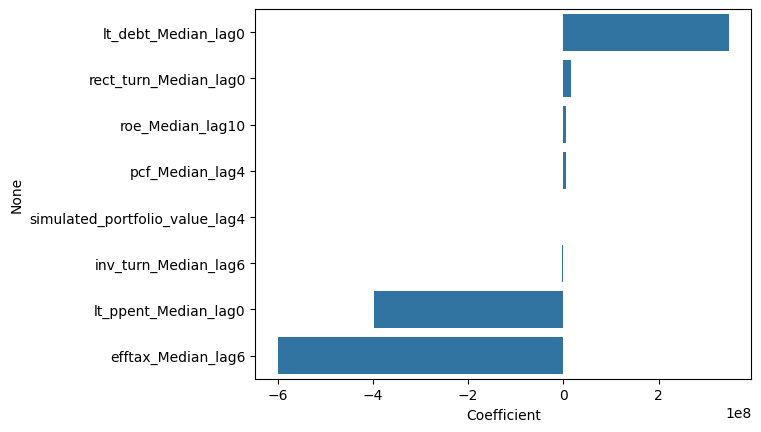

In [21]:
X_train = train_lagged_df[features]
y_train = train_lagged_df[target]
X_test = test_lagged_df[features]
y_test = test_lagged_df[target]

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

# Optional: Print model coefficients
coef_df = pd.DataFrame(model.coef_, index=features, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)
# print(coef_df)
sns.barplot(x='Coefficient', y=coef_df.index, data=coef_df)


In [22]:
# Convert the predictions to a flat array
y_pred_flat = np.array(y_pred).flatten()

# Convert the predictions and the test data to percentage change
actual_predictions = pd.Series(y_pred_flat).diff()[1:]
actual_y_test = pd.Series(y_test).diff()[1:]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_y_test, actual_predictions))
mae = mean_absolute_error(actual_y_test, actual_predictions)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 2011467621.0515733
MAE: 850127061.0780134
